In [1]:
import pandas as pd
import numpy as np
import typing as tp
import matplotlib
from catboost import CatBoostRegressor

In [2]:
stat_df = pd.read_csv('train.csv')

In [3]:
def iter_over_dataset(df: pd.DataFrame):
    columns_known_before_match = ['Division', 'Time', 'home_team', 'Referee', 'away_team', 'home_coef', 'draw_coef',
       'away_coef']
    for _, row in df.iterrows():
        yield True, row[columns_known_before_match] # is before match, information 
        yield False, row

def get_team_profitability(teams_profitability: tp.Dict[int, tp.List], team_id, n_matches):
    if team_id in teams_profitability:
        return np.mean(teams_profitability[team_id][-n_matches:])
    else:
        return 0

def calculate_last_matches_profitability(df: pd.DataFrame, n_matches=5):
    teams_profitability: tp.Dict[int, tp.List] = dict()
    iterator = iter_over_dataset(df)
    for match_not_happened, row in iterator:
        if match_not_happened:
            home_team_profitability = get_team_profitability(teams_profitability, row['home_team'], n_matches)
            away_team_profitability = get_team_profitability(teams_profitability, row['away_team'], n_matches)
            yield home_team_profitability, away_team_profitability
        else:
            bet_on_home_profit = row['home_coef'] * (row['full_time_home_goals'] > row['full_time_away_goals']) - 1
            if row['home_team'] in teams_profitability:
                teams_profitability[row['home_team']].append(bet_on_home_profit)
            else:
                teams_profitability[row['home_team']] = [bet_on_home_profit]
                
            bet_on_away_profit = row['away_coef'] * (row['full_time_home_goals'] < row['full_time_away_goals']) - 1
            if row['away_team'] in teams_profitability:
                teams_profitability[row['away_team']].append(bet_on_away_profit)
            else:
                teams_profitability[row['away_team']] = [bet_on_away_profit]
    global current_profitability
    current_profitability = teams_profitability

In [4]:
for n_matches in range(1, 10, 2):
    print(n_matches)
    profits = []
    for row in calculate_last_matches_profitability(stat_df, n_matches):
        profits.append(row)
    df = pd.DataFrame(profits, columns=[f'home_profit_{n_matches}', f'away_profit_{n_matches}'])
    stat_df = stat_df.merge(df, left_index=True, right_index=True)

1
3
5
7
9


In [5]:
stat_df['bet_home_profit'] = stat_df['home_coef'] * \
        (stat_df['full_time_home_goals'] > stat_df['full_time_away_goals']) - 1
stat_df['bet_away_profit'] = stat_df['away_coef'] * \
        (stat_df['full_time_home_goals'] < stat_df['full_time_away_goals']) - 1
stat_df['bet_draw_profit'] = stat_df['draw_coef'] * \
        (stat_df['full_time_home_goals'] == stat_df['full_time_away_goals']) - 1

In [6]:
# feature_columns = [column for column in stat_df.columns if '_profit_' in column]
feature_columns = [column for column in stat_df.columns if ('_profit_' in column)]
feature_columns.append('Division')

X_train = stat_df[feature_columns].iloc[:30000]
y_train = stat_df['bet_home_profit'].iloc[:30000]
bet_draw_train = stat_df['bet_draw_profit'].iloc[:30000]
bet_away_train = stat_df['bet_away_profit'].iloc[:30000]


X_test = stat_df[feature_columns].iloc[30001:]
y_test = stat_df['bet_home_profit'].iloc[30001:]


bet_away_test = stat_df['bet_away_profit'].iloc[30001:]
bet_draw_test = stat_df['bet_draw_profit'].iloc[30001:]

In [7]:
#define top quantile trade for catboost 
class top_quantile_trade(object):
    def __init__(self, quantile=0.8):
        self.quantile = quantile
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.
        
        # weight parameter can be None.
        # Returns pair (error, weights sum)
        approxes = approxes[0]
        norm_predict = []
        norm_target = []
        for index in range(len(target)):
            norm_predict.append(approxes[index])
            norm_target.append(target[index])
        quantile = np.quantile(norm_predict, self.quantile)
        loss = 0
        for index in range(len(target)):
            if norm_predict[index] > quantile:
                loss += norm_target[index]
        return (loss / ((1-self.quantile) * len(target)), 0)
    
    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

In [8]:
reg = CatBoostRegressor(iterations=300, custom_metric=['R2', 'MAE'], eval_metric=top_quantile_trade(0.95),
                        use_best_model=False, random_seed=42)
reg.fit(X_train, y_train, plot=True, verbose=False, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
result = pd.DataFrame({'predict_home':reg.predict(X_test), 
                       'bet_home_return':y_test,
                       'bet_away_return':bet_away_test, 'bet_draw_return':bet_draw_test})
result

predict_home  bet_home_return  bet_away_return  bet_draw_return
30001      0.153274        -1.000000        -1.000000         3.333728
30002      0.136143         1.130884        -1.000000        -1.000000
30003      0.083508         0.463867        -1.000000        -1.000000
30004     -0.102238         0.214521        -1.000000        -1.000000
30005     -0.087528         2.340613        -1.000000        -1.000000
...             ...              ...              ...              ...
39987      0.135238        -1.000000         3.155226        -1.000000
39988      0.226182         0.340170        -1.000000        -1.000000
39989      0.110157        -1.000000         3.638715        -1.000000
39990      0.194307        -1.000000        -1.000000         2.852988
39991      0.110473        -1.000000        -1.000000         2.924194

[9991 rows x 4 columns]

-0.002746568029393014 500


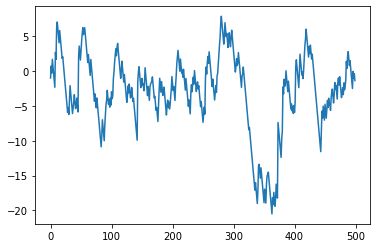

In [12]:
quantile_home = result['predict_home'].quantile(0.95)

rule_home = (result['predict_home']>quantile_home)

profits = pd.Series(result[rule_home]['bet_home_return'].to_list())
profits.cumsum().plot()
print(profits.mean(), len(profits))

In [13]:
quantile_home

0.30201978757349207

In [14]:
import json

with open('current_profitability.json', 'w') as fp:
    json.dump(current_profitability, fp)

In [15]:
reg.save_model('model.cbm')